In [1]:
# standard loads
import numpy as np #type:ignore
import matplotlib.pyplot as plt #type:ignore
from matplotlib.colors import ListedColormap #type:ignore
from matplotlib.colors import LinearSegmentedColormap #type:ignore
import pandas as pd #type:ignore
import h5py #type:ignore
from skimage import morphology #type:ignore
from skimage.morphology import skeletonize #type:ignore
from skimage.morphology import dilation, disk #type: ignore
from scipy import ndimage #type: ignore
import time
from scipy.spatial.distance import pdist


# import specific algorithm functions
from readvardef import readvardef
from Loadlidarmaps import Loadlidarmaps
from RemoveaboveHAT import RemoveaboveHAT


%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display, uncomment while working

In [2]:
# User input files
# manual input, as opposed to MATLAB script's GUI selection
basename_UserVar = 'UserVar_sb.txt' 
filepath_input_folder = '/Users/sam/RDE Dropbox/Projects/22386.Ashleyville Marsh/WORK/CODE/Python/CHIROL_CREEK_EXTRACTION_ALGORITHM/INPUTS/'

filename_UserVar = filepath_input_folder+basename_UserVar

In [3]:
# Section 1 - CHIROL_CREEK_ALGORITHM_OPL.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/09/1

# 1) User to select input variables
# import specific algorithm functions
from readvardef import readvardef

start_time = time.time()

# 1) User to select input variables
figview = 0  # Change to 1 to see additional figures

# Open User Variables instruction file
result = readvardef(filename_UserVar)
if result is None:
    print("User aborted or error occurred.")
    exit()

FILENAMES, PROCESSING, TIDE, THRESHOLDS, RECONNECTION = result

# Unpack data from global variables
name = FILENAMES["name"]
shortname = FILENAMES["shortname"]
elev = FILENAMES["elev"]
elevmeta = FILENAMES["elevmeta"]
slope = FILENAMES["slope"]
slopemeta = FILENAMES["slopemeta"]

resamplestep = PROCESSING["resamplestep"]
threshold = PROCESSING["threshold"]
detrendyn = PROCESSING["detrendyn"]
outletdetection = PROCESSING["outletdetection"]

HAT = TIDE["HAT"]
MHWS = TIDE["MHWS"]
MHWN = TIDE["MHWN"]
MLWS = TIDE["MLWS"]
MLWN = TIDE["MLWN"]

Cth = THRESHOLDS["Cth"]
Ctharea = THRESHOLDS["Ctharea"]
LZth = THRESHOLDS["LZth"]
LZtharea = THRESHOLDS["LZtharea"]
HZth = THRESHOLDS["HZth"]
HZtharea = THRESHOLDS["HZtharea"]

nbbreaches = RECONNECTION["nbbreaches"]
noisethreshold = RECONNECTION["noisethreshold"]
reconnect = RECONNECTION["reconnect"]
reconnectiondist = RECONNECTION["reconnectiondist"]
ordermax = RECONNECTION["ordermax"]
filtersmall1 = RECONNECTION["filtersmall1"]
filterlarge1 = RECONNECTION["filterlarge1"]
smoothing = RECONNECTION["smoothing"]
connectivity = RECONNECTION["connectivity"]
holesizeinfill = RECONNECTION["holesizeinfill"]
filtersmall2 = RECONNECTION["filtersmall2"]
filterlarge2 = RECONNECTION["filterlarge2"]

#  Print out the values to verify they were read correctly
# print("Loaded variables:")
# for category in [FILENAMES, PROCESSING, TIDE, THRESHOLDS, RECONNECTION]:
#     for key, value in category.items():
#         print(f"{key}: {value}")

end_time = time.time()
# print(f"Execution time: {end_time - start_time} seconds")

In [ ]:
# Section 2 - CHIROL_CREEK_ALGORITHM_OPL.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/09/15

# 2) Load in initial datasets: elevation and slope maps
# Dataset = year-specific, gap infilled DSM at 1m resolution obtained via Geomatics Group
# open datasets. Area is delimited either by flood defences, HAT values, or
# in the case of the mature saltmarshes studied by Steel (1996), the area limits
# established by their field surveys
# A second dataset is the slope map of the MR area in degrees

# import specific algorithm functions
from Loadlidarmaps import Loadlidarmaps
from RemoveaboveHAT import RemoveaboveHAT

# Load the data
Xs, Ys, Zs, X, Y, Z, gs, xc, yc = Loadlidarmaps(elev, elevmeta, slope, slopemeta)

# Remove values above HAT
Z, Zs, meandepth, meanslope = RemoveaboveHAT(Z, Zs, HAT, detrendyn)

# Print some information about the loaded and processed data
print(f"Data loaded and processed:")
print(f"X range: {np.min(X)} to {np.max(X)} meters")
print(f"Y range: {np.min(Y)} to {np.max(Y)} meters")
print(f"Z range: {np.nanmin(Z)} to {np.nanmax(Z)} meters")
print(f"Mean depth: {meandepth} meters")
print(f"Mean slope: {meanslope} degrees")
print(f"Grid size: {gs} meters")

# Subsample the dataset to make mapping quicker
# X2 = X[::resamplestep, ::resamplestep]
# Y2 = Y[::resamplestep, ::resamplestep]
X2 = X[::resamplestep] # was 2D in MATLAB, I guess not 2D in Python?
Y2 = Y[::resamplestep] # was 2D in MATLAB, I guess not 2D in Python?
Z2 = Z[::resamplestep, ::resamplestep]

print(f"Subsampled data shape: {Z2.shape}")

Data loaded and processed:
X range: 702282.822 to 702558.6659999957 meters
Y range: 104798.62199999919 to 105078.27600000009 meters
Z range: -0.5817052125930786 to 1.2217533588409424 meters
Mean depth: 0.47373840643948184 meters
Mean slope: 1.8795210029425342 degrees
Grid size: 0.762 meters
Subsampled data shape: (181, 184)


In [5]:
# Section 3 - CHIROL_CREEK_ALGORITHM_OPL.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/12/29

# 3) Load creekmask

# Define paths
A = 'OUTPUTS/'
B = '_creekmask'
string_creek = f'{A}{shortname}{B}'

# Load the h5 file
with h5py.File(string_creek + '.h5', 'r') as f:
    creekmask = f['creek_mask'][:]  # Assuming 'creekmask' is the dataset name in the h5 file

# Calculate area
AREA_CREEK = np.nansum(creekmask)

In [6]:
# Section 4 - CHIROL_CREEK_ALGORITHM_OPL.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/12/29

# 4) Remove outliers

# Remove values above HAT
Z[Z > HAT] = np.nan
# Calculate elevation under HAT
elev_under_hat = HAT - np.nanmean(Z)
# Flip arrays
Z = np.flipud(Z)  # equivalent to MATLAB's flip
creekmask = np.flipud(creekmask)
# Create marsh elevation array
Zmarsh = Z.copy()  # Create a copy to avoid modifying original
Zmarsh[creekmask] = np.nan
# Calculate mean elevations
MARSH_ELEV = np.nanmean(Zmarsh)
MEAN_ELEV = np.nanmean(Z)

In [7]:
# Section 5 - CHIROL_CREEK_ALGORITHM_OPL.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/12/29

# 5) areamask = logical matrix with non-NaN values = 1 and NaN values = 0

# Create logical matrix (areamask)
areamask = np.ones_like(Z, dtype=bool)  # equivalent to MATLAB's true(size(Z))
areamask[np.isnan(Z)] = False
# Calculate catchment area
CATCHMENT = np.sum(areamask)  # no need for "omitmissing" since we've handled NaNs\
# Create MHWS mask
areaMHWS = areamask.copy()  # Create a copy to avoid modifying original
areaMHWS[Z < MHWS] = False

In [8]:
# Section 6 - CHIROL_CREEK_ALGORITHM_OPL.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/12/29

# 6) Calculate the distance to the creek network using bwdist

# Calculate distance transform (equivalent to bwdist)
# Note: bwdist in MATLAB finds distance to nearest non-zero pixel
# We need to invert creekmask since scipy's distance_transform_edt finds distance to nearest zero
D = ndimage.distance_transform_edt(~creekmask) # for each pixel, distance to nearest non-zero pixel
# Remove values outside areamask
D[areamask == 0] = np.nan

# Calculate area (equivalent to bwarea)
# bwarea in MATLAB counts the total number of pixels in binary image
area_val = np.sum(areamask)
# Calculate mean overland path length
mean_OPL = np.nanmean(D)

In [9]:
# Section 7 - CHIROL_CREEK_ALGORITHM_OPL.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/12/29

# 7) Get the major axis length of areamax = theoretical longest distance from creek

# Get perimeter coordinates
kernel = ndimage.generate_binary_structure(2, 2)  # 2 is for 8-connectivity
perimmask = np.logical_xor(areamask, ndimage.binary_erosion(areamask, kernel))
Xarea, Yarea = np.nonzero(perimmask)
# Create array of perimeter coordinates - each row is [x,y]
points_perim = np.array(list(zip(Xarea, Yarea)), dtype=float)
# Create array of X,Y coordinates - each row is [x,y]
# Assuming X and Y are your original coordinate arrays
points = np.array(list(zip(X.flatten(), Y.flatten())), dtype=float)

# Calculate pairwise distances and find maximum
# Compute only unique pairwise distances (more efficient)
distances = pdist(points)  # this gives us just the upper triangle of the matrix of distances
maxdist = np.max(distances)
mindist = 0

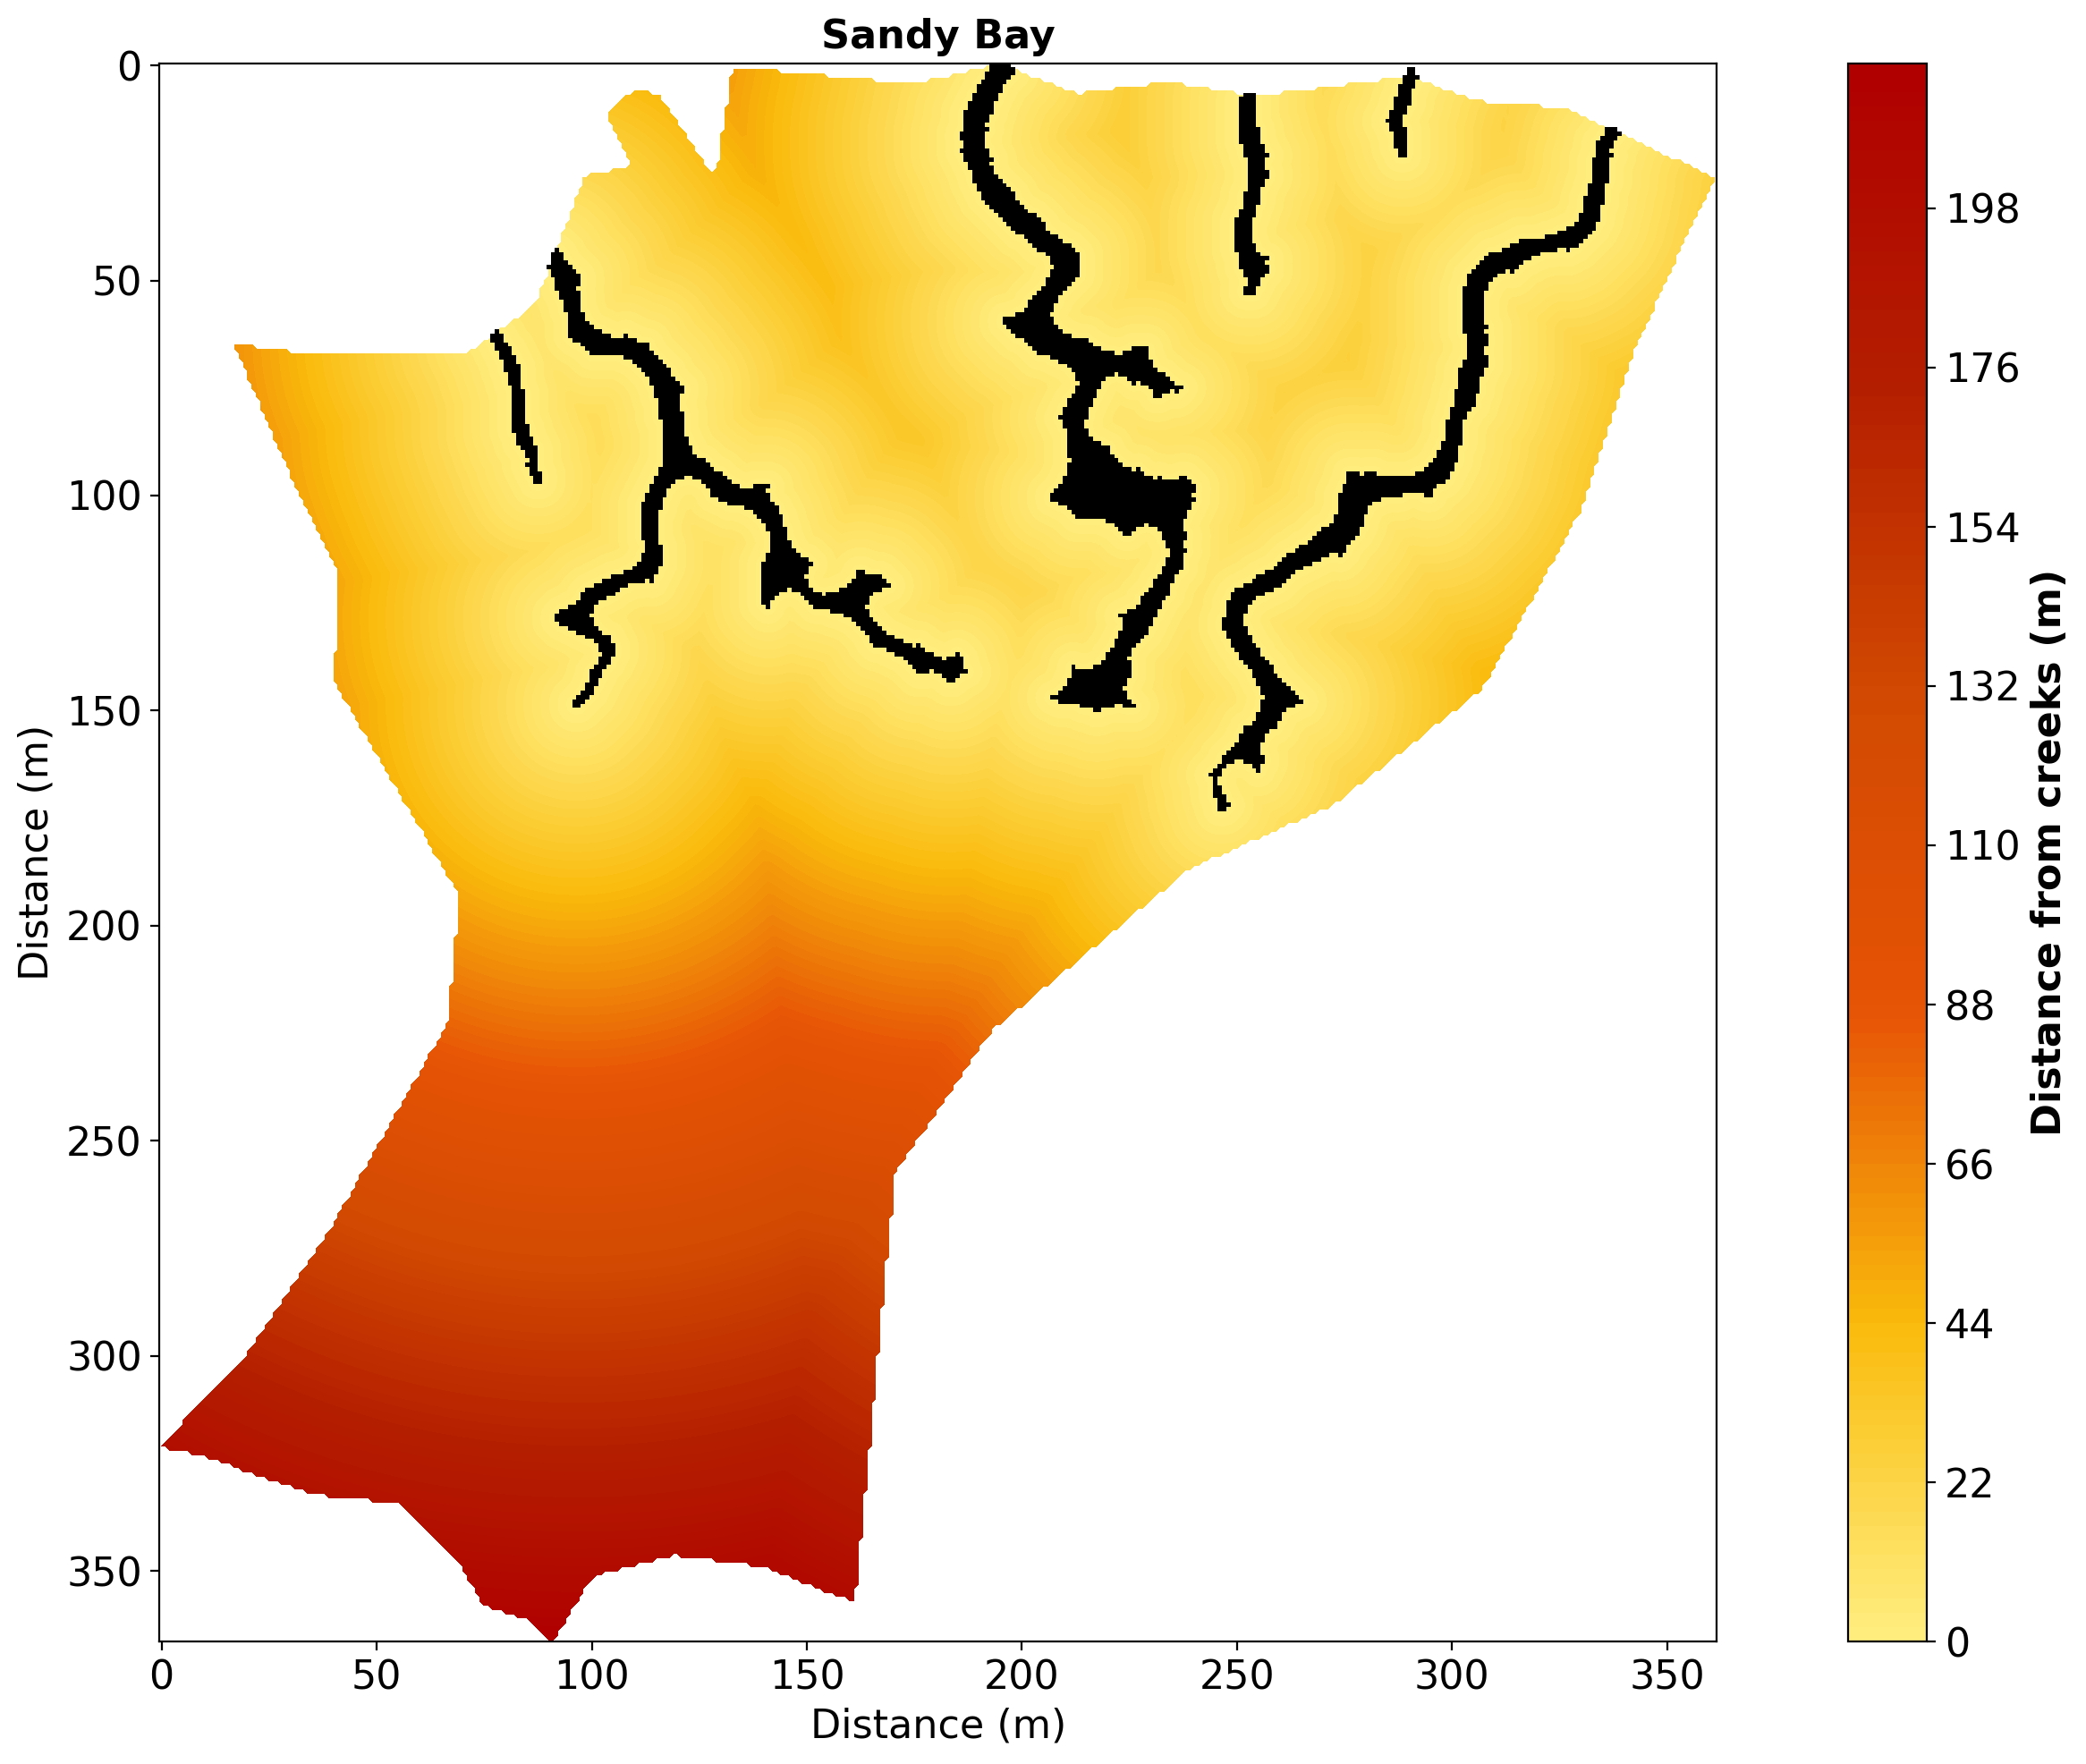

In [10]:
# Section 8 - CHIROL_CREEK_ALGORITHM_OPL.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/12/29

# 8) Plot isocontour

# Calculate distance in percentage of major axis length
Diso = (D / maxdist) * 100
Diso[~areamask] = np.nan
Diso = D  # Note: this overwrites previous calculations

# Define contour values
mincontval = np.nanmin(Diso)
maxcontval = np.nanmax(Diso)

# Set contour intervals based on max value
if maxcontval >= 10:
    contval = np.arange(mincontval, maxcontval + 2, 2)
elif maxcontval >= 4:
    contval = np.arange(mincontval, maxcontval + 1, 1)
else:
    contval = np.arange(mincontval, maxcontval + 0.5, 0.5)

# Create figure
plt.figure(figsize=(15, 10))

# Prepare masks for plotting
creekmask_pic = np.where(creekmask, 1, np.nan)
areamask_pic = np.where(areamask, 1, np.nan)

# Define custom colormap
colors = np.array([
    [255, 238, 128],
    [250, 187, 12],
    [230, 83, 5],
    [210, 74, 2],
    [180, 30, 0],
    [176, 0, 0]
]) / 255.0

# Create custom colormap interpolated to match number of contours
num_levels = len(contval)
colors_interp = np.zeros((num_levels, 3))
for i in range(3):  # For each RGB channel
    colors_interp[:, i] = np.interp(
        np.linspace(0, 1, num_levels),
        np.linspace(0, 1, len(colors)),
        colors[:, i]
    )
custom_cmap = LinearSegmentedColormap.from_list('custom', colors_interp)

# Transpose and flip the Diso array for contour plotting
Diso = np.fliplr(Diso.T)

# Plot filled contours
cf = plt.contourf(Diso, levels=contval, cmap=custom_cmap, zorder=1)
plt.clim(mincontval, maxcontval)

# Plot creek mask in black
# Transpose and flip for contour plotting
creekmask_pic = np.fliplr(creekmask_pic.T)
plt.imshow(creekmask_pic, cmap='gray', alpha=1.0, zorder=2)
# # To add area mask in gray (if needed):
# plt.imshow(areamask_pic, cmap='gray', alpha=0.1)

# Customize plot
plt.title(name, fontsize=16, fontweight='bold')
cbar = plt.colorbar(cf)
cbar.set_label('Distance from creeks (m)', fontsize=16, fontweight='bold')
cbar.ax.tick_params(labelsize=16)

plt.xlabel('Distance (m)', fontsize=16)
plt.ylabel('Distance (m)', fontsize=16)
plt.gca().set_aspect('equal')
plt.gca().tick_params(labelsize=16)

plt.tight_layout()
plt.show()

In [11]:
# Section 9 - CHIROL_CREEK_ALGORITHM_OPL.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/12/29

# 9) Calculate tidal prism

# Check for NaNs in Z matrix
if np.any(np.isnan(Z)):
   print('Warning: The elevation matrix Z contains NaN values. These will be ignored in the volume calculation.')

# Initialize total volume
potential_volume = 0

# Calculate volume using vectorized operations instead of loop
elevation_diff = HAT - Z
# Only count positive differences (where HAT is above elevation)
elevation_diff = np.where(elevation_diff > 0, elevation_diff, 0)
# Sum up all valid differences (ignoring NaNs)
potential_volume = np.nansum(elevation_diff)

# Display the calculated potential volume
print(f'Potential volume of the tidal creek: {potential_volume:.2f} cubic meters')

Potential volume of the tidal creek: 128375.17 cubic meters
